In [ ]:
from sys import path
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import logging
logging.getLogger("pypsa").setLevel(logging.ERROR)

BASE_DIR = Path.cwd()
path.append(str(BASE_DIR.parent))

from custom_package.Plot_Helper_funcs import *
from custom_package.Class_funcs import *

data_file = BASE_DIR / "Timeseries_3.156_101.691_E5_1kWp_crystSi_14_0deg_-1deg_2023_2023.csv"

c:\Users\royro\Desktop\Solar_PPAs


This Notebook models the cost to service 1 kW of constant load under different tarrif designs: fully grid-powered, monthly netting CRESS and hourly matching CRESS with and without nightly grid charging

In [2]:
arr = np.loadtxt(data_file, 
                 delimiter=',', 
                 skiprows=23, 
                 usecols=(1))

solar_profile = np.concatenate((np.zeros(8), arr[:-8]))/1000
solar_profile *= 1500/np.sum(solar_profile) # Scale to 1.5 MWh/year

config = {#Sen/kWh
    # "snapshots": range(len(solar_profile)),
    "holiday_arr": [0, 28, 29, 89, 90, 120, 131, 152, 157, 177, 242, 248, 257, 292, 357], # based on 2025, https://www.mytnb.com.my/tariff/index.html?v=1.1.47#faq
    "peak_hours": np.arange(13,22), # 2pm to 10pm
    "peak_profile_simplistic": False,
    "peak_profile": None, # Optional
    "grid_import_profile": np.array((np.arange(len(solar_profile)) % 24) < 8, dtype=int),
	"solar_profile": solar_profile,
    "kW_solar": 3, # kW
    "battery_efficiency": 0.9,
    "BESS_capacity": 8,
}

config["finanicials"] = {"wheeling_charge": 20, # sen/kWh
                         "electricity_price_grid": 0, # sen/kWh, already included in peak and off-peak charge
							"capacity_charge": 21.76*100, # sen/kW/month,
							"network_charge": 23.06*100, # sen/kW/month,
							"off_peak_charge": 51.09,
							"peak_charge": 55.18,
                            "peak_charge_plus": 18,
							"green_electricity_tariff": 5.0,
						 	"PV_per_kWp": 180, # MYR per kWp
                            "BESS_per_kWh": 48, # MYR per kWh
							"grid_charging_tariff": 60, # sen/kWh, IN TOTAL: inbetween 
                            "peak_quadratic_cost": 10
						 }


Fully Grid-Powered

Number of peak hours in the year: 2241.0
total_capacity_charge     537.84
peak_tariff_charge        1348.6338
offpeak_tariff_charge     3656.5071000000003
solar yearly cost         0
battery yearly cost       0
wheeling charge           0
grid_charging_tariff      0
total cost year:       5542.9809000000005
5542.9809000000005


Text(0.5, 1.0, 'Tariff compostion for Fully Grid-Powered System')

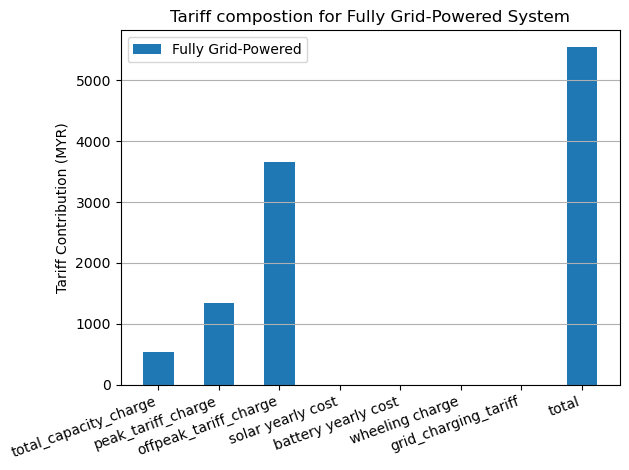

In [3]:
CRESS0 = CRESS_network("no_grid_charging", config, label=f"Grid powered")

CRESS0.initialize_network()

grid_powered_dict = CRESS0.fully_grid_powered(print_bool=True)
print(sum(grid_powered_dict.values()))

plot_pretty_bar_chart([grid_powered_dict], ["Fully Grid-Powered"],)

plt.title(f"Tariff compostion for Fully Grid-Powered System")

Monthly Netting CRESS

In [4]:
CRESS = CRESS_network("no_grid_charging", config, label=f"CRESS with no Grid Charging, {config['kW_solar']}kW solar, {config['BESS_capacity']}kWh BESS")

CRESS.initialize_network()

CRESS.n.optimize(
    solver_name="highs",
    solver_options={
        "solver": "ipm",
        "presolve": "on",          # default, but make explicit
        "parallel": "on",
        "threads": 8,              # match your CPU cores
        "time_limit": 3600,        # seconds   
    }
)

Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 87.14it/s]
INFO:linopy.io: Writing time: 1.31s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.49e+05
Solver model: available
Solver message: Optimal



('ok', 'optimal')

CRESS kWh per year 4343.399297793367
total_capacity_charge     537.84
peak_tariff_charge        0.0
offpeak_tariff_charge     2477.271333867701
solar yearly cost         540
battery yearly cost       384
wheeling charge           868.6798595586733
grid_charging_tariff      0
total cost year:       4807.791193426374
Monthly matching tariff breakdown (MYR): 


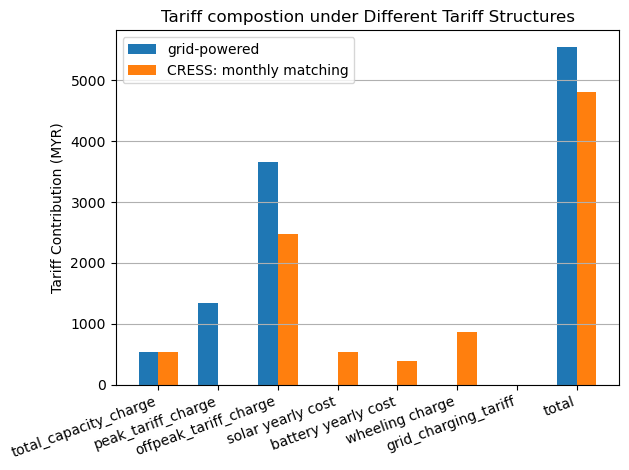

In [5]:
tariff_dict = CRESS.monthly_matching_costs(optimize=False, print_bool=True)

print("Monthly matching tariff breakdown (MYR): ")

plot_pretty_bar_chart([grid_powered_dict, tariff_dict], ["grid-powered", "CRESS: monthly matching"])

Hourly Matching without Grid Charging

Worst day index: 21 35.21406755711976
total_capacity_charge     147.47102778225565
peak_tariff_charge        21.191825855874672
offpeak_tariff_charge     2457.519763374913
solar yearly cost         540
battery yearly cost       384
wheeling charge           868.6798595586733
grid_charging_tariff      0.0
total cost year:       4418.862476571717


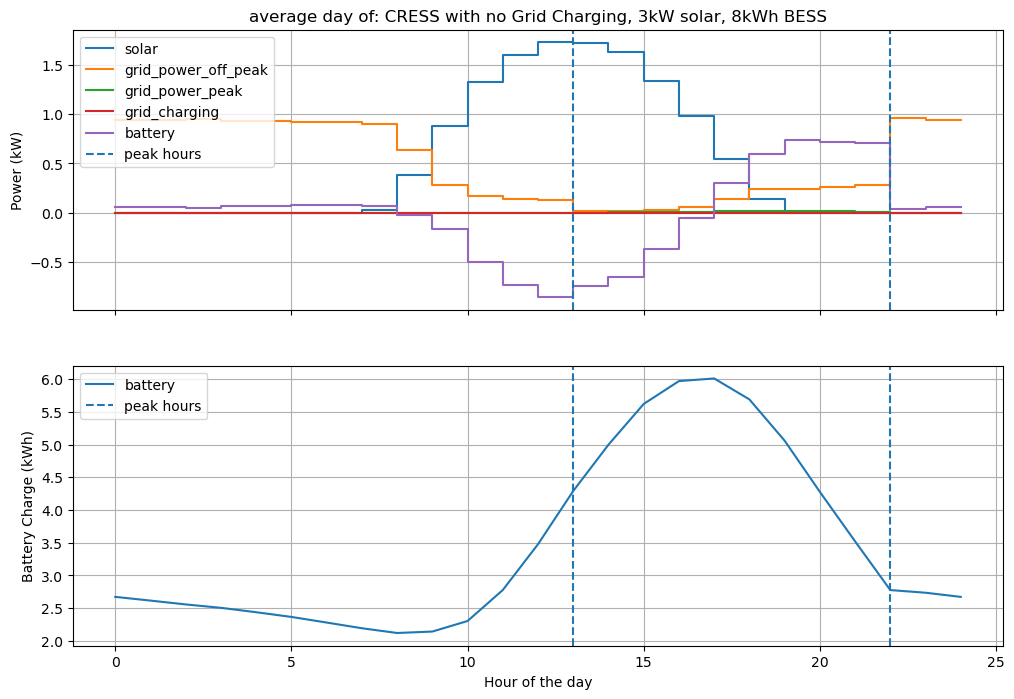

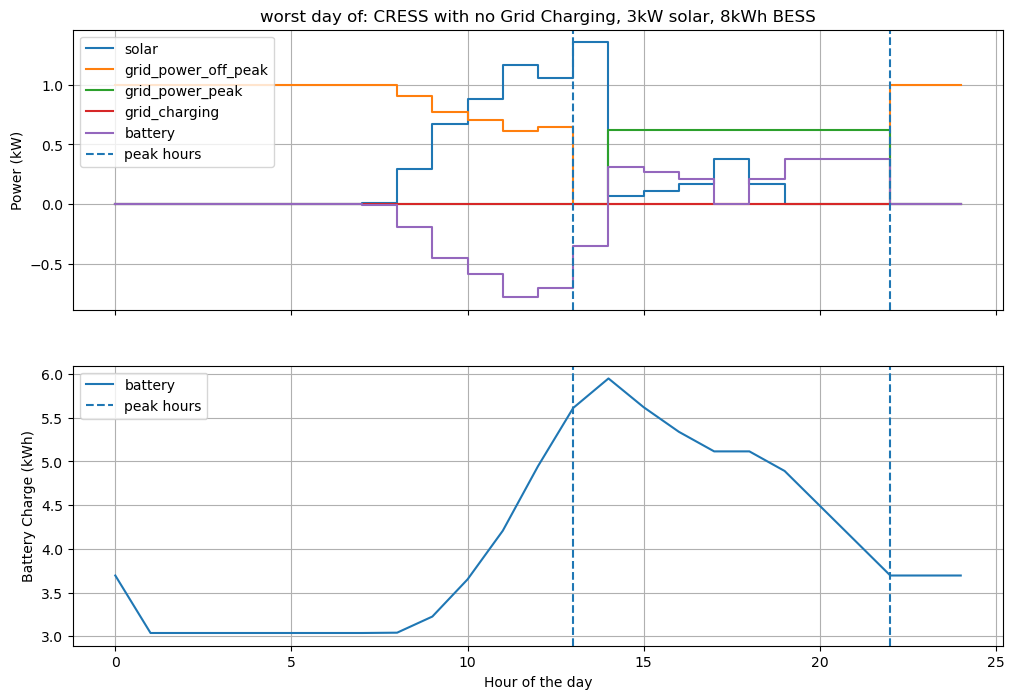

In [6]:
CRESS.plot_average_day(battery_SOC=True)

CRESS.plot_worst_day(battery_SOC=True)

CRESS_dict = CRESS.hourly_matching_costs(print_bool=True)

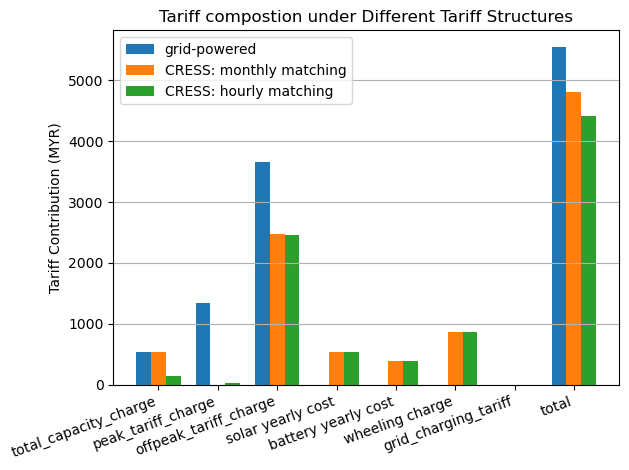

In [7]:
plot_pretty_bar_chart([grid_powered_dict, 
                       tariff_dict, 
                       CRESS_dict], 
                       ["grid-powered", 
                        "CRESS: monthly matching", 
                        "CRESS: hourly matching"])

Hourly Matching CRESS with Grid Charging

In [8]:
CRESS_grid_charging = CRESS_network("grid_charging", config, label=f"CRESS with Grid Charging, {config['kW_solar']}kW solar, {config['BESS_capacity']}kWh BESS")

CRESS_grid_charging.initialize_network()

CRESS_grid_charging.n.optimize(
    solver_name="highs",
    solver_options={
        "solver": "ipm",
        "presolve": "on",          # default, but make explicit
        "parallel": "on",
        "threads": 8,              # match your CPU cores
        "time_limit": 3600,        # seconds   
    }
)

Number of peak hours in the year: 2241.0


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
 - presolve: on
 - parallel: on
 - threads: 8
 - time_limit: 3600
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 90.37it/s]
INFO:linopy.io: Writing time: 1.34s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87600 primals, 166439 duals
Objective: 2.48e+05
Solver model: available
Solver message: Optimal



('ok', 'optimal')

total_capacity_charge     0.0
peak_tariff_charge        0.0
offpeak_tariff_charge     2457.519763374913
solar yearly cost         540
battery yearly cost       384
wheeling charge           867.8973247240707
grid_charging_tariff      23.476045038079842
total cost year:       4272.893133137064
Worst day index: 23 0.0


(array([<Axes: title={'center': 'worst day of: CRESS with Grid Charging, 3kW solar, 8kWh BESS'}, ylabel='Power (kW)'>,
        <Axes: xlabel='Hour of the day', ylabel='Battery Charge (kWh)'>],
       dtype=object),
 <Figure size 1200x800 with 2 Axes>)

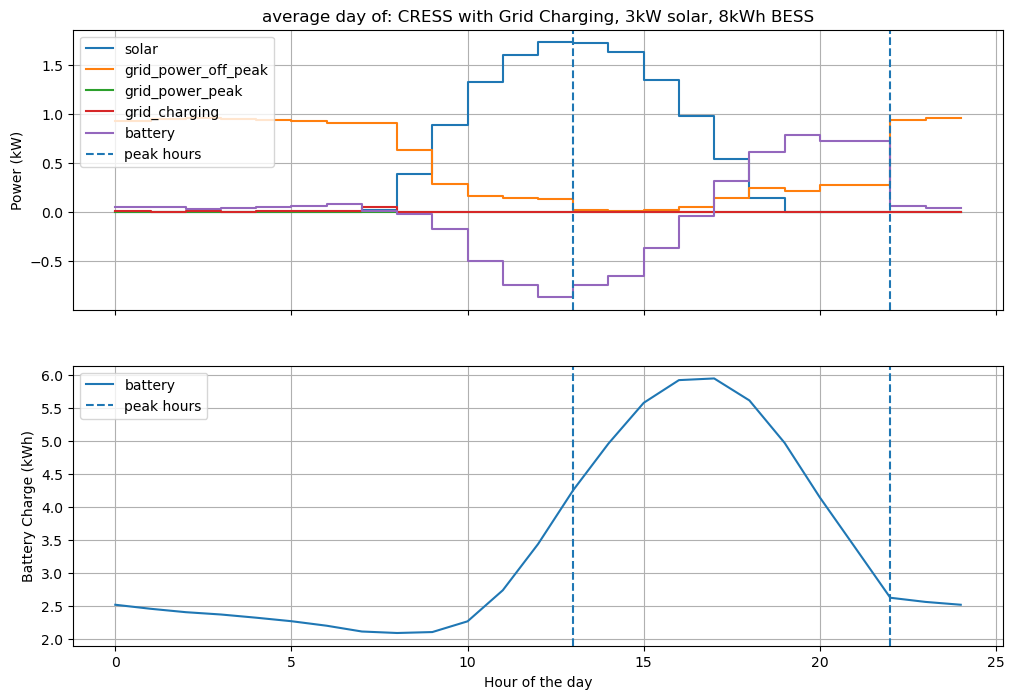

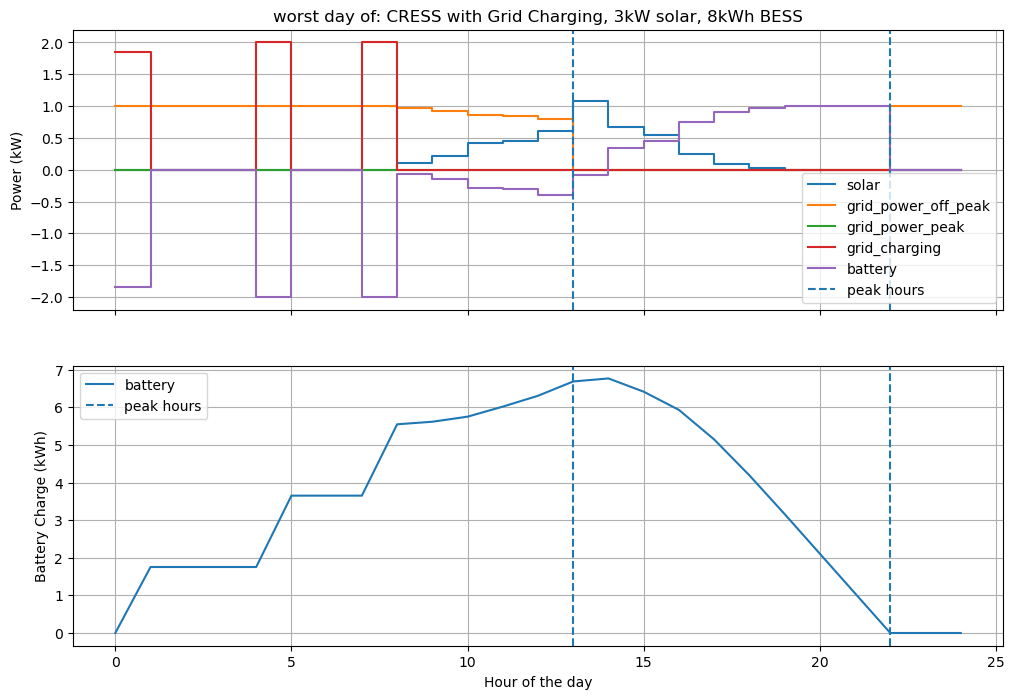

In [9]:
CRESS_dict2 = CRESS_grid_charging.hourly_matching_costs(print_bool=True)

CRESS_grid_charging.plot_average_day(battery_SOC=True)

CRESS_grid_charging.plot_worst_day(battery_SOC=True)

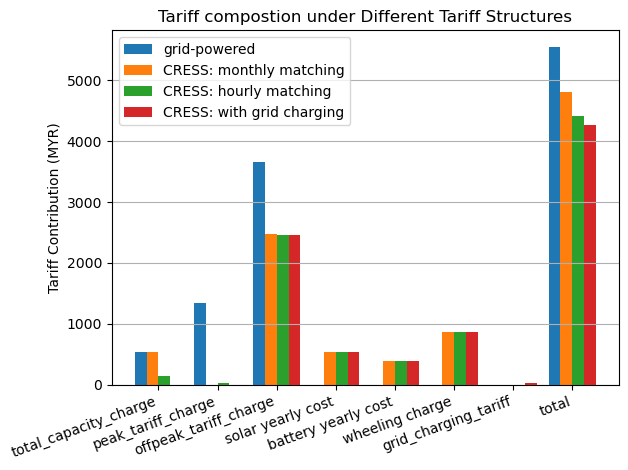

In [10]:
plot_pretty_bar_chart([grid_powered_dict, 
                       tariff_dict, 
                       CRESS_dict,
                       CRESS_dict2], 
                       ["grid-powered", 
                        "CRESS: monthly matching", 
                        "CRESS: hourly matching",
                        "CRESS: with grid charging"])